In [154]:
import pandas as pd
import numpy as np
import re
from nltk.corpus import stopwords # Import the stop word list
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from imblearn.pipeline import make_pipeline
from imblearn.over_sampling import RandomOverSampler

# Import CountVectorizer and TFIDFVectorizer from feature_extraction.text.
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB, BernoulliNB, GaussianNB

from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.preprocessing import FunctionTransformer

# Data Inspection Section

###  Purpose of this section: Ensure that data was loaded into the notebook properly. Examine dimensions of dataframe to verify new webscrapes were appended properly. 

#### Remove Null Values from Data

In [100]:
# Load CSV files into DataFrames
censored_train_df = pd.read_csv('../data/censored_train.csv')
y_train_df = pd.read_csv('../data/y_train.csv')

# Find rows with NaN values in the train set
nan_indices = censored_train_df.index[censored_train_df.isnull().any(axis=1)]

# Remove rows with NaN values from the train set
censored_train_df = censored_train_df.dropna()

# Remove corresponding rows from the label data
y_train_df = y_train_df.drop(nan_indices)

# Convert DataFrame columns to lists or Series
censored_posts_train = censored_train_df['posts'].tolist()
y_train = y_train_df['label']

# Convert y_train to Series if needed
y_train = pd.Series(y_train)

In [101]:
# Load CSV files into DataFrames
censored_test_df = pd.read_csv('../data/censored_test.csv')
y_test_df = pd.read_csv('../data/y_test.csv')

# Find rows with NaN values in the test set
nan_indices_test = censored_test_df.index[censored_test_df.isnull().any(axis=1)]

# Remove rows with NaN values from the test set
censored_test_df = censored_test_df.dropna()

# Remove corresponding rows from the label data for the test set
y_test_df = y_test_df.drop(nan_indices_test)

# Convert DataFrame columns to lists or Series for the test set
censored_posts_test = censored_test_df['posts'].tolist()
y_test = y_test_df['label']

# Convert y_test to Series if needed
y_test = pd.Series(y_test)

#### Verify these were loaded and converted correctly

In [102]:
type(censored_posts_train)

list

In [103]:
type(censored_posts_test)

list

In [104]:
type(y_train)

pandas.core.series.Series

In [105]:
type(y_test)

pandas.core.series.Series

# Baseline accuracy
Calculate baseline accuracy in order to tell if model is better than null model (predicting the plurality class).

In [106]:
df = pd.read_csv('../data/final_df_to48.csv')

In [107]:
#null model dem 1 rep 0?
df['subreddit'].value_counts(normalize=True)

subreddit
1    0.528996
0    0.471004
Name: proportion, dtype: float64

In [108]:
# Baseline prediction dem 1 rep 0
y_train.value_counts(normalize=True)

label
1    0.511753
0    0.488247
Name: proportion, dtype: float64

In [109]:
print(f"Difference metric | {round(np.abs(np.mean(df['subreddit'])-np.mean(y_train)), 5)}")

Difference metric | 0.01724


Absolute difference: ($\sim2\%$). 

# Logistic Regression Section 

### Proceeded with `GridSearchCV` and found some optimal choices for CVec then utilized these parameters in a well-defined function along with Logistic Regression fitting.

In [111]:
# Example pipeline 

pipe1 = Pipeline([
    ('cvec', CountVectorizer()),
    ('lr',LogisticRegression())
])

pipe2 = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('lr',LogisticRegression())
])

pipe_params1 = {'cvec__max_features': list(np.arange(5000, 10000, 1000)),
               'cvec__ngram_range': [(1,1), (1,2), (1,3)],
                'cvec__min_df': [0.00005, 0.0001],
                'cvec__max_df': [0.6,0.65,0.7],
               'cvec__stop_words': [None, 'english','combined_stopwords']
              }

pipe_params2 = {'tvec__max_features' : list(np.arange(5000, 10000, 1000)),
               'tvec__ngram_range' : [(1, 1), (1, 2), (1,3)],
                'tvec__min_df': [0.00005, 0.0001],
                'tvec__max_df': [0.6,0.65,0.7],
                'tvec__stop_words': [None, 'english','combined_stopwords']
              }

# Instantiate GridSearchCV.

gs1 = GridSearchCV(pipe3, # what object are we optimizing?
                  param_grid=pipe_params3, # what parameters values are we searching?
                  cv=5) # 5-fold cross-validation.

gs2 = GridSearchCV(pipe4, # what object are we optimizing?
                  param_grid=pipe_params4, # what parameters values are we searching?
                  cv=5) # 5-fold cross-validation.

gs1.fit(censored_posts_train, y_train)

gs2.fit(censored_posts_train, y_train)

/Users/ben/miniforge3/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
450 fits failed out of a total of 1350.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
450 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/ben/miniforge3/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/ben/miniforge3/lib/python3.10/site-packages/sklearn/base.py", line 1151, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/Users/ben/miniforge3/lib/python3.10/site-packages/imblearn/pipeline.py", line 322, in fit
    Xt, yt = self._fit(X, y, routed_params

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tvec', TfidfVectorizer()),
                                       ('lr', LogisticRegression())]),
             param_grid={'tvec__max_df': [0.6, 0.65, 0.7],
                         'tvec__max_features': [5000, 6000, 7000, 8000, 9000],
                         'tvec__min_df': [5e-05, 0.0001],
                         'tvec__ngram_range': [(1, 1), (1, 2), (1, 3)],
                         'tvec__stop_words': [None, 'english',
                                              'combined_stopwords']})

#### Performed a `GridSearch` to find optimal features to create the best-performing CVEC, as this performed better than TVec in conjunction to the logistic regression during accuracy comparisons between test and train scores.

In [112]:
best_cvec = CountVectorizer(
    max_df=0.6, 
    max_features=9000, 
    min_df=5e-05, # The optimal value is 5e05
    ngram_range=(1, 2), 
    stop_words = None # The optimal parameter is None
)

During `GridSearch` it was revealed that optimal stopwords parameter was `None`, thus, the custom list of stopwords were not utilized. 

#### Transform the censored posts using the best performing CountVectorizer.

In [113]:
X_train_cvec = best_cvec.fit_transform(censored_posts_train)
X_test_cvec =  best_cvec.transform(censored_posts_test)

### Scale data

In [114]:
ss = StandardScaler(with_mean=False)

X_train_ss = ss.fit_transform(X_train_cvec)
X_test_ss = ss.transform(X_test_cvec)


## Optimize Logistic Regression by utilizing a GridSearch Algorithm

### Search for a better $C$ value, where $C$ is the inverse of regularization strength $\alpha$; inverse of regularization strength. A Higher $C$ value means lower regularization. Smaller $C$ value means higher regularization. Increase regularization because increasing regularization is a better technique than reducing the number of features to overcome the overfitting problem.

In [115]:
from sklearn.model_selection import GridSearchCV
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100]}
grid_search = GridSearchCV(LogisticRegression(max_iter=10000, penalty='l1', solver='liblinear'), param_grid, cv=5)
grid_search.fit(X_train_ss, y_train)

print("Best parameters: ", grid_search.best_params_)

Best parameters:  {'C': 0.1}


### Print out Train and Test Scores

In [118]:
print(f"Train Accuracy Score | {round(grid_search.score(X_train_ss, y_train),3)}")
print(f"Test Accuracy Score | {round(grid_search.score(X_test_ss, y_test),3)}")

Train Accuracy Score | 0.987
Test Accuracy Score | 0.897


TN: 126
FP: 19
FN: 15
TP: 170


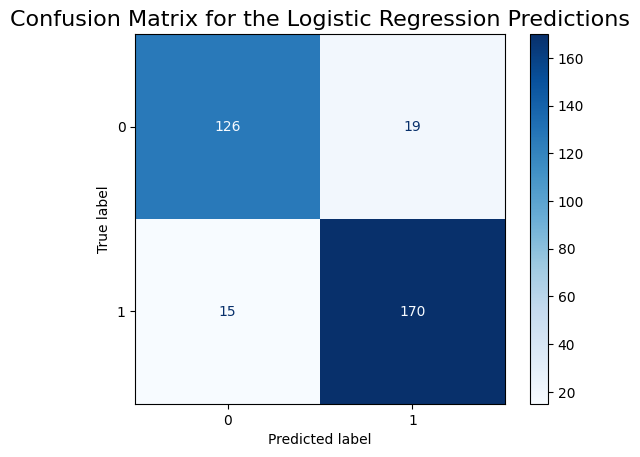

In [119]:
# Get predictions from optimal LR model
preds = grid_search.predict(X_test_ss)
# Save confusion matrix values
tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()

# Generate values of confusion matrix for reference
def find_cm(y_test, preds):
    tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()
    
    return f"TN: {tn}\nFP: {fp}\nFN: {fn}\nTP: {tp}" 
    
# View confusion matrix
ConfusionMatrixDisplay.from_estimator(grid_search, X_test_ss, y_test, cmap='Blues');
plt.title('Confusion Matrix for the Logistic Regression Predictions',fontsize=16, loc='center');

print(find_cm(y_test, preds))

In [180]:
print(f"Values being correctly classified: {tp} democrat posts, {tn} republican posts.")
print(f"Values being incorrectly classified: {fn} democrat posts being predicted as republican posts, {fp} republican posts being predicted as democrat posts.")

Values being correctly classified: 170 democrat posts, 126 republican posts.
Values being incorrectly classified: 15 democrat posts being predicted as republican posts, 19 republican posts being predicted as democrat posts.


### These figures will inform how the classification metrics results will materialize

In [120]:
# Calculate Sensitivity
print(f"Sensitivity | {round(tp/(tp+fn),3)}")
# Calculate the Specificity
print(f"Specificity | {round(tn/(tn+fp),3)}")
# Calculate Accuracy
print(f"Accuracy | {round((tp+tn)/(tp+fp+tn+fn),3)}")
# Calculate Precision
print(f"Precision | {round(tp/(tp+fp),3)}")
# Calculate Miscalculation Rate
print(f"Miscalculation Rate | {round((fp+fn)/(tp+fp+tn+fn),3)}")

Sensitivity | 0.919
Specificity | 0.869
Accuracy | 0.897
Precision | 0.899
Miscalculation Rate | 0.103


### Since the goal of the model is to prioritize sensitivity, this result is desired. 

In other words, the positive class is whether the post belonged to the `democrats` subreddit class, denoted by a $1$, therefore, the goal is the achieve a result that yields a high probability of correctly predicting an "actual" positive example. 

Precision is also also high, that is, the probability that the model is correct when it predicts an example to be in the positive class. In this value, a desired result is accomplished.

# Support Vector Machine (SVM) Section

### Disclaimer: This model performed well, and outperformed $\textit{Naive Bayes}$ statistical models and $\textit{logistic regression}$, with train in upper 90s and test in low 90s. The other models, aside from $\textit{logistic regression}$, have been excluded for brevity.  

#### Performed a `GridSearch` (not shown) to find optimal features to create the best-performing TVEC, as this performed better than CVec in conjunction to the SVM during accuracy comparisons between test and train scores (not shown).

In [121]:
# Example pipeline 

pipe3 = Pipeline([
    ('cvec', CountVectorizer()),
    ('svm',SVC())
])

pipe4 = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('svm',SVC())
])

pipe_params3 = {'cvec__max_features': list(np.arange(5000, 10000, 1000)),
               'cvec__ngram_range': [(1,1), (1,2), (1,3)],
                'cvec__min_df': [0.00005, 0.0001],
                'cvec__max_df': [0.6,0.65,0.7],
               'cvec__stop_words': [None, 'english','combined_stopwords']
              }

pipe_params4 = {'tvec__max_features' : list(np.arange(5000, 10000, 1000)),
               'tvec__ngram_range' : [(1, 1), (1, 2), (1,3)],
                'tvec__min_df': [0.00005, 0.0001],
                'tvec__max_df': [0.6,0.65,0.7],
                'tvec__stop_words': [None, 'english','combined_stopwords']
              }

# Instantiate GridSearchCV.

gs3 = GridSearchCV(pipe3, # what object are we optimizing?
                  param_grid=pipe_params3, # what parameters values are we searching?
                  cv=5) # 5-fold cross-validation.

gs4 = GridSearchCV(pipe4, # what object are we optimizing?
                  param_grid=pipe_params4, # what parameters values are we searching?
                  cv=5) # 5-fold cross-validation.

gs3.fit(censored_posts_train, y_train)

gs4.fit(censored_posts_train, y_train)

/Users/ben/miniforge3/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
450 fits failed out of a total of 1350.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
450 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/ben/miniforge3/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/ben/miniforge3/lib/python3.10/site-packages/sklearn/base.py", line 1151, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/Users/ben/miniforge3/lib/python3.10/site-packages/imblearn/pipeline.py", line 322, in fit
    Xt, yt = self._fit(X, y, routed_params

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tvec', TfidfVectorizer()),
                                       ('svm', SVC())]),
             param_grid={'tvec__max_df': [0.6, 0.65, 0.7],
                         'tvec__max_features': [5000, 6000, 7000, 8000, 9000],
                         'tvec__min_df': [5e-05, 0.0001],
                         'tvec__ngram_range': [(1, 1), (1, 2), (1, 3)],
                         'tvec__stop_words': [None, 'english',
                                              'combined_stopwords']})

In [122]:
best_tvec = TfidfVectorizer(
    max_df=0.6, 
    max_features=8000, 
    min_df=5e-05,
    ngram_range=(1, 2), 
    stop_words = 'english'
)

#### Transform the censored posts using the best performing TFIDFVectorizer.

In [123]:
X_train_tvec = best_tvec.fit_transform(censored_posts_train)
X_test_tvec =  best_tvec.transform(censored_posts_test)

In [125]:
# Define a parameter grid
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'kernel': ['linear', 'rbf', 'poly'],
    'degree': [2, 3, 4],  # Only applicable for 'poly' kernel
}

# Create the grid search
grid_search_svm = GridSearchCV(SVC(), param_grid, cv=5)
grid_search_svm.fit(X_train_tvec, y_train)

# Print the best parameters
print("Best parameters: ", grid_search.best_params_)

Best parameters:  {'C': 0.1}


### Optimize with RandomOverSampler 
#### It performed poorly compared with regular gridsearch so keep grid_search_svm

In [126]:
# Define a parameter grid for SVC
param_grid_svm = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'kernel': ['linear', 'rbf', 'poly'],
    'degree': [2, 3, 4],  # Only applicable for 'poly' kernel
}

# Create the pipeline with RandomOverSampler and GridSearchCV for SVC
pipe_svm = make_pipeline(
    RandomOverSampler(sampling_strategy="all", random_state=42),
    GridSearchCV(SVC(), param_grid_svm, cv=5)
)

# Fit the pipeline
pipe_svm.fit(X_train_tvec, y_train)

# Access the best parameters found by GridSearchCV for SVC
print("Best parameters for SVC: ", pipe_svm.named_steps['gridsearchcv'].best_params_)

Best parameters for SVC:  {'C': 1, 'degree': 2, 'kernel': 'poly'}


In [127]:
print(f"Train score for SVM Tvec: {pipe_svm.score(X_train_tvec,y_train)}")
print(f"Test score for SVM Tvec: {pipe_svm.score(X_test_tvec,y_test)}")

Train score for SVM Tvec: 0.9929482874412358
Test score for SVM Tvec: 0.9090909090909091


In [128]:
print(f"Train Accuracy Score | {round(grid_search_svm.score(X_train_tvec, y_train),3)}")
print(f"Test Accuracy Score | {round(grid_search_svm.score(X_test_tvec, y_test),3)}")

Train Accuracy Score | 0.993
Test Accuracy Score | 0.909


### These figures will inform how the classification metrics results will materialize

TN: 130
FP: 15
FN: 15
TP: 170


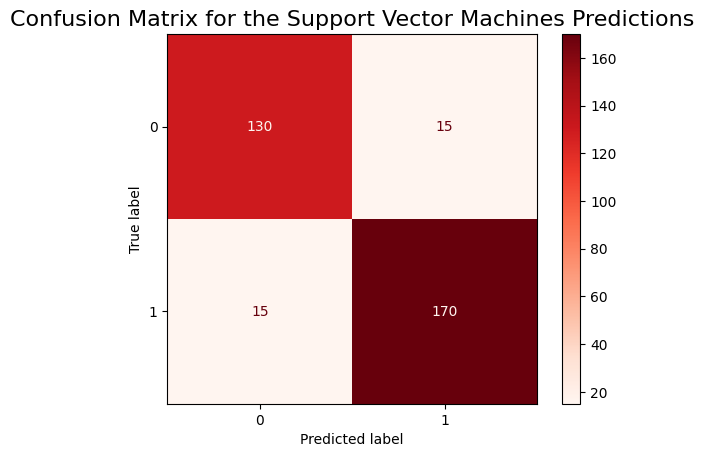

In [210]:
# Get predictions svm
preds_svm = grid_search_svm.predict(X_test_tvec)

# Save confusion matrix values
tn2, fp2, fn2, tp2 = confusion_matrix(y_test, preds_svm).ravel()

# View confusion matrix
ConfusionMatrixDisplay.from_estimator(grid_search_svm, X_test_tvec, y_test, cmap='Reds');
plt.title('Confusion Matrix for the Support Vector Machines Predictions', fontsize=16, loc='center');

# Generate values of confusion matrix for reference
print(find_cm(y_test, preds_svm))

In [181]:
print(f"Values being correctly classified: {tp_svm} democrat posts, {tn_svm} republican posts.")
print(f"Values being incorrectly classified: {fn_svm} democrat posts being predicted as republican posts, {fp_svm} republican posts being predicted as democrat posts.")

Values being correctly classified: 170 democrat posts, 130 republican posts.
Values being incorrectly classified: 15 democrat posts being predicted as republican posts, 15 republican posts being predicted as democrat posts.


In [211]:
# Calculate Sensitivity
print(f"Sensitivity | {round(tp2/(tp2+fn2),3)}")
# Calculate the Specificity
print(f"Specificity | {round(tn2/(tn2+fp2),3)}")
# Calculate Accuracy
print(f"Accuracy | {round((tp2+tn2)/(tp2+fp2+tn2+fn2),3)}")
# Calculate Precision
print(f"Precision | {round(tp2/(tp2+fp2),3)}")
# Calculate Miscalculation Rate
print(f"Miscalculation Rate | {round((fp2+fn2)/(tp2+fp2+tn2+fn2),3)}")

Sensitivity | 0.919
Specificity | 0.897
Accuracy | 0.909
Precision | 0.919
Miscalculation Rate | 0.091


### Since the goal of the model is to prioritize sensitivity, this result is desired. 

In other words, the positive class is whether the post belonged to the `democrats` subreddit class, denoted by a $1$, therefore, the goal is to achieve a result that yields a high probability of correctly predicting an "actual" positive example. 

Precision is also high, that is, the probability that the model is correct when it predicts an example to be in the positive class. For this value, a desired outcome is accomplished.

Accuracy, the percentage of observations correctly predicted within the test class, has peaked at $90\%$, so another highly appealing result has been achieved. 

Here, $\textit{SVM}$ has outperformed $\textit{logistic regression}$ in nearly all of the aforementioned classification metrics; thus $\textit{SVM}$ is the optimal model at differentiating between the two subreddit classes. 

### Naive Bayes Models

In [133]:
pipe3 = Pipeline([
    ('cvec', CountVectorizer()),
    ('bnb',BernoulliNB())
])

pipe4 = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('bnb',BernoulliNB())
])

In [134]:
pipe_params3 = {'cvec__max_features': list(np.arange(5000, 10000, 1000)),
               'cvec__ngram_range': [(1,1), (1,2), (1,3)],
                'cvec__min_df': [0.00005, 0.0001],
                'cvec__max_df': [0.6,0.65,0.7],
               'cvec__stop_words': [None, 'english']
              }

pipe_params4 = {'tvec__max_features' : list(np.arange(5000, 10000, 1000)),
               'tvec__ngram_range' : [(1, 1), (1, 2), (1,3)],
                'tvec__min_df': [0.00005, 0.0001],
                'tvec__max_df': [0.6,0.65,0.7],
                'tvec__stop_words': [None, 'english']
              }

In [135]:
# Instantiate GridSearchCV.

gs3 = GridSearchCV(pipe3, # what object are we optimizing?
                  param_grid=pipe_params3, # what parameters values are we searching?
                  cv=5) # 5-fold cross-validation.

gs4 = GridSearchCV(pipe4, # what object are we optimizing?
                  param_grid=pipe_params4, # what parameters values are we searching?
                  cv=5) # 5-fold cross-validation.

In [136]:
gs3.fit(censored_posts_train, y_train)

gs4.fit(censored_posts_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tvec', TfidfVectorizer()),
                                       ('bnb', BernoulliNB())]),
             param_grid={'tvec__max_df': [0.6, 0.65, 0.7],
                         'tvec__max_features': [5000, 6000, 7000, 8000, 9000],
                         'tvec__min_df': [5e-05, 0.0001],
                         'tvec__ngram_range': [(1, 1), (1, 2), (1, 3)],
                         'tvec__stop_words': [None, 'english']})

In [137]:
print(f"Train score for Bern CountVec: {gs3.score(censored_posts_train, y_train)}")
print(f"Test score for Bern CountVec: {gs3.score(censored_posts_test, y_test)}")

Train score for Bern CountVec: 0.9375419744795165
Test score for Bern CountVec: 0.8545454545454545


In [138]:
print(f"Train score for Bern TfidfVec: {gs4.score(censored_posts_train, y_train)}")
print(f"Test score for Bern TfidfVec: {gs4.score(censored_posts_test, y_test)}")

Train score for Bern TfidfVec: 0.9375419744795165
Test score for Bern TfidfVec: 0.8545454545454545


In [139]:
print(gs3.best_params_)
print(gs4.best_params_)

{'cvec__max_df': 0.6, 'cvec__max_features': 5000, 'cvec__min_df': 5e-05, 'cvec__ngram_range': (1, 1), 'cvec__stop_words': None}
{'tvec__max_df': 0.6, 'tvec__max_features': 5000, 'tvec__min_df': 5e-05, 'tvec__ngram_range': (1, 1), 'tvec__stop_words': None}


Specificity | 0.8275862068965517
Sensitivity | 0.8756756756756757
Accuracy | 0.855
Precision | 0.866
Miscalculation Rate | 0.145


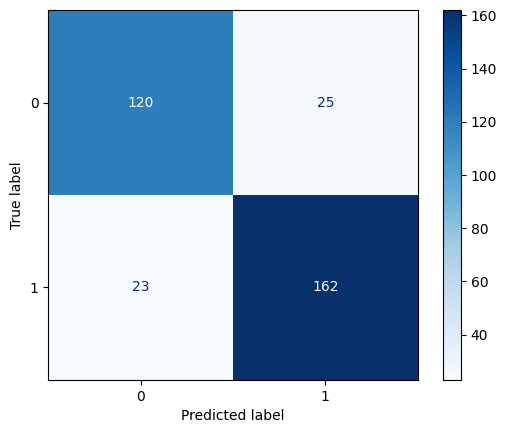

In [175]:
# Get predictions gs1
preds3 = gs3.predict(censored_posts_test)
# Save confusion matrix values
tn3, fp3, fn3, tp3 = confusion_matrix(y_test, preds3).ravel()

# Get predictions gs2
preds4 = gs4.predict(censored_posts_test)
# Save confusion matrix values
tn4, fp4, fn4, tp4 = confusion_matrix(y_test, preds4).ravel()

# View confusion matrix
ConfusionMatrixDisplay.from_estimator(gs3, censored_posts_test, y_test, cmap='Blues');

# Calculate the specificity
print(f"Specificity | {tn3/(tn3+fp3)}")

# Calculate sensitivity
print(f"Sensitivity | {tp3/(tp3+fn3)}")
# Calculate Accuracy
print(f"Accuracy | {round((tp3+tn3)/(tp3+fp3+tn3+fn3),3)}")
# Calculate Precision
print(f"Precision | {round(tp3/(tp3+fp3),3)}")
# Calculate Miscalculation Rate
print(f"Miscalculation Rate | {round((fp3+fn3)/(tp3+fp3+tn3+fn3),3)}")

In [182]:
print(f"Values being correctly classified: {tp3} democrat posts, {tn3} republican posts.")
print(f"Values being incorrectly classified: {fn3} democrat posts being predicted as republican posts, {fp3} republican posts being predicted as democrat posts.")

Values being correctly classified: 162 democrat posts, 120 republican posts.
Values being incorrectly classified: 23 democrat posts being predicted as republican posts, 25 republican posts being predicted as democrat posts.


Specificity | 0.8275862068965517
Sensitivity | 0.8756756756756757
Accuracy | 0.855
Precision | 0.866
Miscalculation Rate | 0.145


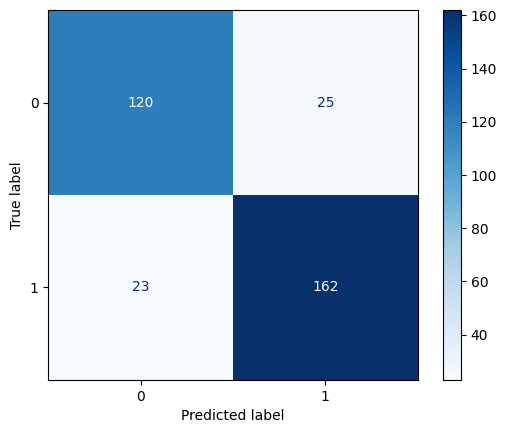

In [174]:
# View confusion matrix
ConfusionMatrixDisplay.from_estimator(gs4, censored_posts_test, y_test, cmap='Blues');

# Calculate the specificity
print(f"Specificity | {tn4/(tn4+fp4)}")

# Calculate sensitivity
print(f"Sensitivity | {tp4/(tp4+fn4)}")
# Calculate Accuracy
print(f"Accuracy | {round((tp4+tn4)/(tp4+fp4+tn4+fn4),3)}")
# Calculate Precision
print(f"Precision | {round(tp4/(tp4+fp4),3)}")
# Calculate Miscalculation Rate
print(f"Miscalculation Rate | {round((fp4+fn4)/(tp4+fp4+tn4+fn4),3)}")

In [183]:
print(f"Values being correctly classified: {tp4} democrat posts, {tn4} republican posts.")
print(f"Values being incorrectly classified: {fn4} democrat posts being predicted as republican posts, {fp4} republican posts being predicted as democrat posts.")

Values being correctly classified: 162 democrat posts, 120 republican posts.
Values being incorrectly classified: 23 democrat posts being predicted as republican posts, 25 republican posts being predicted as democrat posts.


In [142]:
pipe5 = Pipeline([
    ('cvec', CountVectorizer()),
    ('mlt',MultinomialNB())
])

pipe6 = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('mlt',MultinomialNB())
])

In [143]:
pipe_params5 = {'cvec__max_features': list(np.arange(5000, 10000, 1000)),
               'cvec__ngram_range': [(1,1), (1,2), (1,3)],
                'cvec__min_df': [0.00005, 0.0001],
                'cvec__max_df': [0.6,0.65,0.7],
               'cvec__stop_words': [None, 'english']
              }

pipe_params6 = {'tvec__max_features' : list(np.arange(5000, 10000, 1000)),
               'tvec__ngram_range' : [(1, 1), (1, 2), (1,3)],
                'tvec__min_df': [0.00005, 0.0001],
                'tvec__max_df': [0.6,0.65,0.7],
                'tvec__stop_words': [None, 'english']
              }

In [144]:
# Instantiate GridSearchCV.

gs5 = GridSearchCV(pipe5, # what object are we optimizing?
                  param_grid=pipe_params5, # what parameters values are we searching?
                  cv=5) # 5-fold cross-validation.

gs6 = GridSearchCV(pipe6, # what object are we optimizing?
                  param_grid=pipe_params6, # what parameters values are we searching?
                  cv=5) # 5-fold cross-validation.

In [145]:
gs5.fit(censored_posts_train, y_train)

gs6.fit(censored_posts_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tvec', TfidfVectorizer()),
                                       ('mlt', MultinomialNB())]),
             param_grid={'tvec__max_df': [0.6, 0.65, 0.7],
                         'tvec__max_features': [5000, 6000, 7000, 8000, 9000],
                         'tvec__min_df': [5e-05, 0.0001],
                         'tvec__ngram_range': [(1, 1), (1, 2), (1, 3)],
                         'tvec__stop_words': [None, 'english']})

In [146]:
print(f"Train score for Multi CountVec: {gs5.score(censored_posts_train, y_train)}")
print(f"Test score for Multi CountVec: {gs5.score(censored_posts_test, y_test)}")

Train score for Multi CountVec: 0.9378777703156481
Test score for Multi CountVec: 0.8454545454545455


In [147]:
print(f"Train score for Multi TfidfVec: {gs6.score(censored_posts_train, y_train)}")
print(f"Test score for Multi TfidfVec: {gs6.score(censored_posts_test, y_test)}")

Train score for Multi TfidfVec: 0.9519811954331766
Test score for Multi TfidfVec: 0.8545454545454545


In [148]:
print(gs5.best_params_)
print(gs6.best_params_)

{'cvec__max_df': 0.6, 'cvec__max_features': 5000, 'cvec__min_df': 5e-05, 'cvec__ngram_range': (1, 1), 'cvec__stop_words': 'english'}
{'tvec__max_df': 0.6, 'tvec__max_features': 9000, 'tvec__min_df': 5e-05, 'tvec__ngram_range': (1, 2), 'tvec__stop_words': None}


Specificity | 0.8344827586206897
Sensitivity | 0.8540540540540541
Accuracy | 0.845
Precision | 0.868
Miscalculation Rate | 0.155


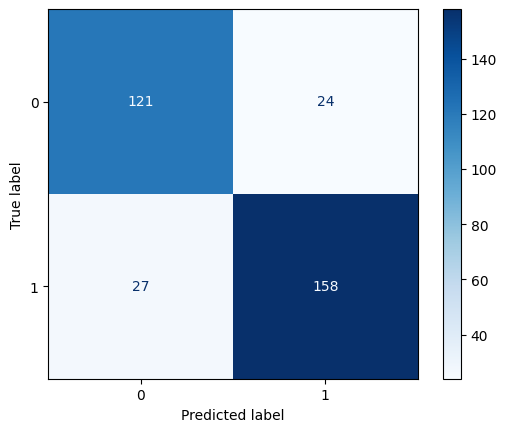

In [176]:
# Get predictions gs1
preds5 = gs5.predict(censored_posts_test)
# Save confusion matrix values
tn5, fp5, fn5, tp5 = confusion_matrix(y_test, preds5).ravel()

# Get predictions gs2
preds6 = gs6.predict(censored_posts_test)
# Save confusion matrix values
tn6, fp6, fn6, tp6 = confusion_matrix(y_test, preds6).ravel()

# View confusion matrix
ConfusionMatrixDisplay.from_estimator(gs5, censored_posts_test, y_test, cmap='Blues');

# Calculate the specificity
print(f"Specificity | {tn5/(tn5+fp5)}")

# Calculate sensitivity
print(f"Sensitivity | {tp5/(tp5+fn5)}")
# Calculate Accuracy
print(f"Accuracy | {round((tp5+tn5)/(tp5+fp5+tn5+fn5),3)}")
# Calculate Precision
print(f"Precision | {round(tp5/(tp5+fp5),3)}")
# Calculate Miscalculation Rate
print(f"Miscalculation Rate | {round((fp5+fn5)/(tp5+fp5+tn5+fn5),3)}")

In [184]:
print(f"Values being correctly classified: {tp5} democrat posts, {tn5} republican posts.")
print(f"Values being incorrectly classified: {fn5} democrat posts being predicted as republican posts, {fp5} republican posts being predicted as democrat posts.")

Values being correctly classified: 158 democrat posts, 121 republican posts.
Values being incorrectly classified: 27 democrat posts being predicted as republican posts, 24 republican posts being predicted as democrat posts.


Specificity | 0.8758620689655172
Sensitivity | 0.8378378378378378
Accuracy | 0.855
Precision | 0.896
Miscalculation Rate | 0.145


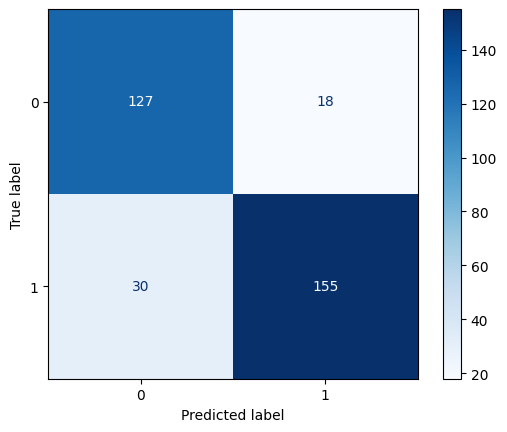

In [177]:
# View confusion matrix
ConfusionMatrixDisplay.from_estimator(gs6, censored_posts_test, y_test, cmap='Blues');

# Calculate the specificity
print(f"Specificity | {tn6/(tn6+fp6)}")

# Calculate sensitivity
print(f"Sensitivity | {tp6/(tp6+fn6)}")
# Calculate Accuracy
print(f"Accuracy | {round((tp6+tn6)/(tp6+fp6+tn6+fn6),3)}")
# Calculate Precision
print(f"Precision | {round(tp6/(tp6+fp6),3)}")
# Calculate Miscalculation Rate
print(f"Miscalculation Rate | {round((fp6+fn6)/(tp6+fp6+tn6+fn6),3)}")

In [185]:
print(f"Values being correctly classified: {tp6} democrat posts, {tn6} republican posts.")
print(f"Values being incorrectly classified: {fn6} democrat posts being predicted as republican posts, {fp6} republican posts being predicted as democrat posts.")

Values being correctly classified: 155 democrat posts, 127 republican posts.
Values being incorrectly classified: 30 democrat posts being predicted as republican posts, 18 republican posts being predicted as democrat posts.


### Gaussian Naive - Bayes (LONG RUNTIME)

In [155]:
def convert_to_dense(X):
    return X.toarray()

pipe7 = Pipeline([
    ('cvec', CountVectorizer()),
    ('to_dense', FunctionTransformer(convert_to_dense, accept_sparse=True)),
    ('gss',GaussianNB())
])

pipe8 = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('to_dense', FunctionTransformer(convert_to_dense, accept_sparse=True)),
    ('gss',GaussianNB())
])

In [156]:
pipe_params7 = {'cvec__max_features': list(np.arange(5000, 10000, 1000)),
                'cvec__ngram_range' : [(1, 1), (1, 2), (1,3)],
                'cvec__min_df': [0.00005, 0.0001],
                'cvec__max_df': [0.6,0.65,0.7],
               'cvec__stop_words': [None, 'english']
              }

pipe_params8 = {'tvec__max_features' : list(np.arange(5000, 10000, 1000)),
                'tvec__ngram_range' : [(1, 1), (1, 2), (1,3)],
                'tvec__min_df': [0.00005, 0.0001],
                'tvec__max_df': [0.6,0.65,0.7],
                'tvec__stop_words': [None, 'english']
              }

In [158]:
# Instantiate GridSearchCV.

gs7 = GridSearchCV(pipe7, # what object are we optimizing?
                  param_grid=pipe_params7, # what parameters values are we searching?
                  cv=5) # 5-fold cross-validation.

gs8 = GridSearchCV(pipe8, # what object are we optimizing?
                  param_grid=pipe_params8, # what parameters values are we searching?
                  cv=5) # 5-fold cross-validation.

In [159]:
gs7.fit(censored_posts_train, y_train)

gs8.fit(censored_posts_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tvec', TfidfVectorizer()),
                                       ('to_dense',
                                        FunctionTransformer(accept_sparse=True,
                                                            func=<function convert_to_dense at 0x145bc3520>)),
                                       ('gss', GaussianNB())]),
             param_grid={'tvec__max_df': [0.6, 0.65, 0.7],
                         'tvec__max_features': [5000, 6000, 7000, 8000, 9000],
                         'tvec__min_df': [5e-05, 0.0001],
                         'tvec__ngram_range': [(1, 1), (1, 2), (1, 3)],
                         'tvec__stop_words': [None, 'english']})

In [160]:
print(f"Train score for Gaussian CountVec: {gs7.score(censored_posts_train, y_train)}")
print(f"Test score for Gaussian CountVec: {gs7.score(censored_posts_test, y_test)}")

Train score for Gaussian CountVec: 0.9546675621222297
Test score for Gaussian CountVec: 0.8333333333333334


In [161]:
print(f"Train score for Gaussian TfidfVec: {gs8.score(censored_posts_train, y_train)}")
print(f"Test score for Gaussian TfidfVec: {gs8.score(censored_posts_test, y_test)}")

Train score for Gaussian TfidfVec: 0.9617192746809939
Test score for Gaussian TfidfVec: 0.8363636363636363


In [162]:
print(gs7.best_params_)
print(gs8.best_params_)

{'cvec__max_df': 0.6, 'cvec__max_features': 5000, 'cvec__min_df': 5e-05, 'cvec__ngram_range': (1, 1), 'cvec__stop_words': None}
{'tvec__max_df': 0.6, 'tvec__max_features': 5000, 'tvec__min_df': 5e-05, 'tvec__ngram_range': (1, 1), 'tvec__stop_words': None}


In [163]:
gs_model7 = gs7.best_estimator_
gs_model8 = gs8.best_estimator_

In [164]:
gs_model7.fit(censored_posts_train, y_train)
gs_model8.fit(censored_posts_train, y_train)

Pipeline(steps=[('tvec',
                 TfidfVectorizer(max_df=0.6, max_features=5000, min_df=5e-05)),
                ('to_dense',
                 FunctionTransformer(accept_sparse=True,
                                     func=<function convert_to_dense at 0x145bc3520>)),
                ('gss', GaussianNB())])

In [165]:
print(gs_model7.score(censored_posts_train, y_train))
print(gs_model7.score(censored_posts_test, y_test))

0.9546675621222297
0.8333333333333334


In [166]:
print(gs_model8.score(censored_posts_train, y_train))
print(gs_model8.score(censored_posts_test, y_test))

0.9617192746809939
0.8363636363636363


Specificity | 0.7379310344827587
Sensitivity | 0.9081081081081082
Accuracy | 0.833
Precision | 0.816
Miscalculation Rate | 0.167


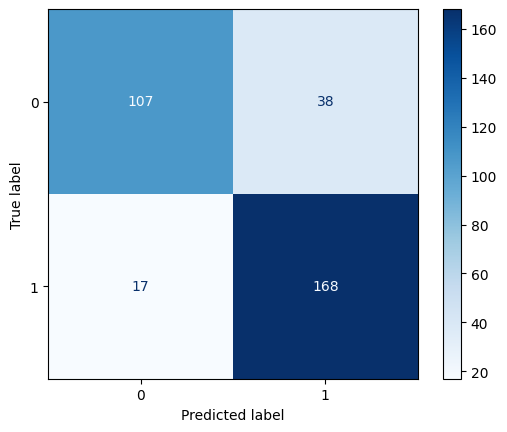

In [178]:
# Get predictions gs7
preds7 = gs_model7.predict(censored_posts_test)
# Save confusion matrix values
tn7, fp7, fn7, tp7 = confusion_matrix(y_test, preds7).ravel()

# Get predictions gs2
preds8 = gs_model8.predict(censored_posts_test)
# Save confusion matrix values
tn8, fp8, fn8, tp8 = confusion_matrix(y_test, preds8).ravel()

# View confusion matrix
ConfusionMatrixDisplay.from_estimator(gs_model7, censored_posts_test, y_test, cmap='Blues');

# Calculate the specificity
print(f"Specificity | {tn7/(tn7+fp7)}")

# Calculate sensitivity
print(f"Sensitivity | {tp7/(tp7+fn7)}")
# Calculate Accuracy
print(f"Accuracy | {round((tp7+tn7)/(tp7+fp7+tn7+fn7),3)}")
# Calculate Precision
print(f"Precision | {round(tp7/(tp7+fp7),3)}")
# Calculate Miscalculation Rate
print(f"Miscalculation Rate | {round((fp7+fn7)/(tp7+fp7+tn7+fn7),3)}")

In [186]:
print(f"Values being correctly classified: {tp7} democrat posts, {tn7} republican posts.")
print(f"Values being incorrectly classified: {fn7} democrat posts being predicted as republican posts, {fp7} republican posts being predicted as democrat posts.")

Values being correctly classified: 168 democrat posts, 107 republican posts.
Values being incorrectly classified: 17 democrat posts being predicted as republican posts, 38 republican posts being predicted as democrat posts.


Specificity | 0.7586206896551724
Sensitivity | 0.8972972972972973
Accuracy | 0.836
Precision | 0.826
Miscalculation Rate | 0.164


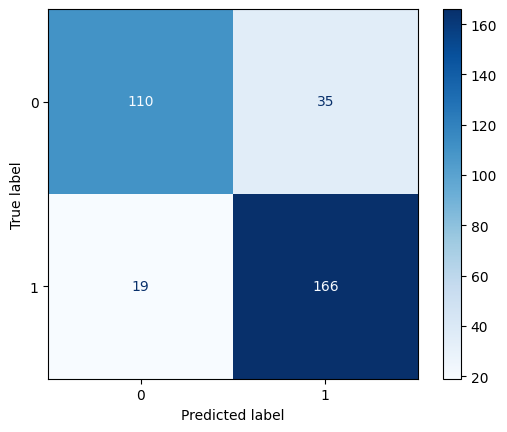

In [179]:
# View confusion matrix
ConfusionMatrixDisplay.from_estimator(gs_model8, censored_posts_test, y_test, cmap='Blues');

# Calculate the specificity
print(f"Specificity | {tn8/(tn8+fp8)}")

# Calculate sensitivity
print(f"Sensitivity | {tp8/(tp8+fn8)}")
# Calculate Accuracy
print(f"Accuracy | {round((tp8+tn8)/(tp8+fp8+tn8+fn8),3)}")
# Calculate Precision
print(f"Precision | {round(tp8/(tp8+fp8),3)}")
# Calculate Miscalculation Rate
print(f"Miscalculation Rate | {round((fp8+fn8)/(tp8+fp8+tn8+fn8),3)}")

In [187]:
print(f"Values being correctly classified: {tp8} democrat posts, {tn8} republican posts.")
print(f"Values being incorrectly classified: {fn8} democrat posts being predicted as republican posts, {fp8} republican posts being predicted as democrat posts.")

Values being correctly classified: 166 democrat posts, 110 republican posts.
Values being incorrectly classified: 19 democrat posts being predicted as republican posts, 35 republican posts being predicted as democrat posts.


### None of these Naive Bayes classifiers outperformed Logistic Regression nor did they outperform the Support Vector Machines classifier. Thus, our chosen models are LR and SVM with their accompanying vectorizers (count vectorizer and tfidfvectorizer respectively). 

# Bonus Section: USE SMOTE

In [169]:
from imblearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Define a parameter grid for SVC
param_grid_svm = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'kernel': ['linear', 'rbf', 'poly'],
    'degree': [2, 3, 4],  # Only applicable for 'poly' kernel
}

# Create a pipeline with SMOTE, SVC, and GridSearchCV
pipeline = Pipeline([
    ('smote', SMOTE(random_state=42)),
    ('svm', GridSearchCV(SVC(), param_grid_svm, cv=5))
])

# Fit the pipeline
pipeline.fit(X_train_tvec, y_train)

# Predict on the test set
y_pred = pipeline.predict(X_test_tvec)

# Calculate and print the accuracy score
accuracy = accuracy_score(y_test, y_pred)
print("Test Accuracy: {:.2f}%".format(accuracy * 100))

# Access the best parameters found by GridSearchCV for SVC
print("Best parameters for SVC: ", pipeline.named_steps['svm'].best_params_)


Test Accuracy: 91.21%
Best parameters for SVC:  {'C': 1, 'degree': 2, 'kernel': 'poly'}


### Ended up performing worse than the other SVC

### Try with Logistic as well

In [170]:
# Define a parameter grid for Logistic Regression
param_grid_logreg = {
    'C': [0.001, 0.01, 0.1, 1],
    'penalty': ['l2'],
    'max_iter': [5000, 7500, 10000],
    'tol': [1e-3, 1e-4, 1e-5]
}

# Create a pipeline with SMOTE, Logistic Regression, and GridSearchCV
pipeline = Pipeline([
    ('smote', SMOTE(random_state=42)),
    ('logreg', GridSearchCV(LogisticRegression(max_iter=10000), param_grid_logreg, cv=5))
])

# Fit the pipeline
pipeline.fit(X_train_ss, y_train)

# Predict on the test set
y_pred = pipeline.predict(X_test_ss)

# Calculate and print the accuracy score
accuracy = accuracy_score(y_test, y_pred)
print("Test Accuracy: {:.2f}%".format(accuracy * 100))

# Access the best parameters found by GridSearchCV for Logistic Regression
print("Best parameters for Logistic Regression: ", pipeline.named_steps['logreg'].best_params_)

Test Accuracy: 90.30%
Best parameters for Logistic Regression:  {'C': 0.001, 'max_iter': 5000, 'penalty': 'l2', 'tol': 0.001}


### Ended up performing better than the other Log Reg

TN: 136
FP: 9
FN: 23
TP: 162


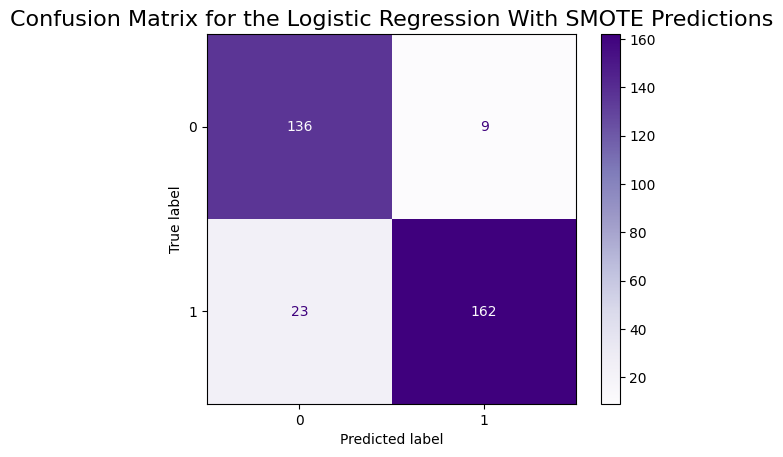

In [171]:
# View confusion matrix
ConfusionMatrixDisplay.from_estimator(pipeline, X_test_ss, y_test, cmap='Purples');
plt.title('Confusion Matrix for the Logistic Regression With SMOTE Predictions',fontsize=16, loc='center');

print(find_cm(y_test, y_pred))

In [188]:
print(f"Values being correctly classified: 162 democrat posts, 136 republican posts.")
print(f"Values being incorrectly classified: 23 democrat posts being predicted as republican posts, 9 republican posts being predicted as democrat posts.")

Values being correctly classified: 162 democrat posts, 136 republican posts.
Values being incorrectly classified: 23 democrat posts being predicted as republican posts, 9 republican posts being predicted as democrat posts.


In [172]:
tn_op_lr, fp_op_lr, fn_op_lr, tp_op_lr = confusion_matrix(y_test, y_pred).ravel()


In [173]:
# Calculate Sensitivity
print(f"Sensitivity | {round(tp_op_lr/(tp_op_lr+fn_op_lr),3)}")
# Calculate the Specificity
print(f"Specificity | {round(tn_op_lr/(tn_op_lr+fp_op_lr),3)}")
# Calculate Accuracy
print(f"Accuracy | {round((tp_op_lr+tn_op_lr)/(tp_op_lr+fp_op_lr+tn_op_lr+fn_op_lr),3)}")
# Calculate Precision
print(f"Precision | {round(tp_op_lr/(tp_op_lr+fp_op_lr),3)}")
# Calculate Miscalculation Rate
print(f"Miscalculation Rate | {round((fp_op_lr+fn_op_lr)/(tp_op_lr+fp_op_lr+tn_op_lr+fn_op_lr),3)}")

Sensitivity | 0.876
Specificity | 0.938
Accuracy | 0.903
Precision | 0.947
Miscalculation Rate | 0.097


### In this BONUS Section, `SMOTE` was utilized to attempt further optimization. Therefore, although the model with `SMOTE` and $\textit{logistic\,regression}$ outperformed the original $\textit{logistic\,regression}$ model, it still did not outperform $\textit{SVM}$. 

# Final Metric Table For Comparison

In [212]:
# Create a dictionary with your metrics
metrics_data = {
    'Metric': ['Specificity', 'Sensitivity', 'Accuracy', 'Precision', 'Miscalculation Rate'],
    'Value SMOTE and LR': [round(tn_op_lr/(tn_op_lr+fp_op_lr),3), round(tp_op_lr/(tp_op_lr+fn_op_lr),3), round((tp_op_lr+tn_op_lr)/(tp_op_lr+fp_op_lr+tn_op_lr+fn_op_lr),3), round(tp_op_lr/(tp_op_lr+fp_op_lr),3), round((fp_op_lr+fn_op_lr)/(tp_op_lr+fp_op_lr+tn_op_lr+fn_op_lr),3)],
    'Gaussian NB TVEC' : [round(tn8/(tn8+fp8),3), round(tp8/(tp8+fn8),3), round((tp8+tn8)/(tp8+fp8+tn8+fn8),3), round(tp8/(tp8+fp8),3), round((fp8+fn8)/(tp8+fp8+tn8+fn8),3)],
    'Gaussian NB CVEC' : [round(tn7/(tn7+fp7),3), round(tp7/(tp7+fn7),3), round((tp7+tn7)/(tp7+fp7+tn7+fn7),3), round(tp7/(tp7+fp7),3), round((fp7+fn7)/(tp7+fp7+tn7+fn7),3)],
    'Multinomial NB TVEC' : [round(tn6/(tn6+fp6),3), round(tp6/(tp6+fn6),3), round((tp6+tn6)/(tp6+fp6+tn6+fn6),3), round(tp6/(tp6+fp6),3), round((fp6+fn6)/(tp6+fp6+tn6+fn6),3)],
    'Multinomial NB CVEC' : [round(tn5/(tn5+fp5),3), round(tp5/(tp5+fn5),3), round((tp5+tn5)/(tp5+fp5+tn5+fn5),3), round(tp5/(tp5+fp5),3), round((fp5+fn5)/(tp5+fp5+tn5+fn5),3)],
    'Bernoulli NB TVEC' : [round(tn4/(tn4+fp4),3), round(tp4/(tp4+fn4),3), round((tp4+tn4)/(tp4+fp4+tn4+fn4),3), round(tp4/(tp4+fp4),3), round((fp4+fn4)/(tp4+fp4+tn4+fn4),3)],
    'Bernoulli NB CVEC' : [round(tn3/(tn3+fp3),3), round(tp3/(tp3+fn3),3), round((tp3+tn3)/(tp3+fp3+tn3+fn3),3), round(tp3/(tp3+fp3),3), round((fp3+fn3)/(tp3+fp3+tn3+fn3),3)],
    'SVM TVEC' : [round(tn2/(tn2+fp2),2), round(tp2/(tp2+fn2),2), round((tp2+tn2)/(tp2+fp2+tn2+fn2),2), round(tp2/(tp2+fp2),2), round((fp2+fn2)/(tp2+fp2+tn2+fn2),2)],
    'LR CVEC' : [round(tn/(tn+fp),3), round(tp/(tp+fn),3), round((tp+tn)/(tp+fp+tn+fn),3), round(tp/(tp+fp),3), round((fp+fn)/(tp+fp+tn+fn),3)]
}

# Create a DataFrame from the dictionary
metrics_df = pd.DataFrame(metrics_data)

"""
print(f"Sensitivity | {round(tp_svm/(tp_svm+fn_svm),3)}")
# Calculate the Specificity
print(f"Specificity | {round(tn_svm/(tn_svm+fp_svm),3)}")
# Calculate Accuracy
print(f"Accuracy | {round((tp_svm+tn_svm)/(tp_svm+fp_svm+tn_svm+fn_svm),3)}")
# Calculate Precision
print(f"Precision | {round(tp_svm/(tp_svm+fp_svm),3)}")
# Calculate Miscalculation Rate
print(f"Miscalculation Rate | {round((fp_svm+fn_svm)/(tp_svm+fp_svm+tn_svm+fn_svm),3)}")
"""


'\nprint(f"Sensitivity | {round(tp_svm/(tp_svm+fn_svm),3)}")\n# Calculate the Specificity\nprint(f"Specificity | {round(tn_svm/(tn_svm+fp_svm),3)}")\n# Calculate Accuracy\nprint(f"Accuracy | {round((tp_svm+tn_svm)/(tp_svm+fp_svm+tn_svm+fn_svm),3)}")\n# Calculate Precision\nprint(f"Precision | {round(tp_svm/(tp_svm+fp_svm),3)}")\n# Calculate Miscalculation Rate\nprint(f"Miscalculation Rate | {round((fp_svm+fn_svm)/(tp_svm+fp_svm+tn_svm+fn_svm),3)}")\n'

In [217]:
metrics_df

,Metric,Value SMOTE and LR,Gaussian NB TVEC,Gaussian NB CVEC,Multinomial NB TVEC,Multinomial NB CVEC,Bernoulli NB TVEC,Bernoulli NB CVEC,SVM TVEC,LR CVEC
0,Specificity,0.938,0.759,0.738,0.876,0.834,0.828,0.828,0.90,0.869
1,Sensitivity,0.876,0.897,0.908,0.838,0.854,0.876,0.876,0.92,0.919
2,Accuracy,0.903,0.836,0.833,0.855,0.845,0.855,0.855,0.91,0.897
3,Precision,0.947,0.826,0.816,0.896,0.868,0.866,0.866,0.92,0.899
4,Miscalculation Rate,0.097,0.164,0.167,0.145,0.155,0.145,0.145,0.09,0.103


### We are justified choosing SVM TVEC and LR CVEC as our models, as they optimize for specificity and precision while also having high accuracy and low misclassification rates